## Supernova distances and redshift

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from astroML.datasets import generate_mu_z
from sklearn.model_selection import train_test_split, KFold, learning_curve
from astroML.linear_model import LinearRegression, PolynomialRegression, BasisFunctionRegression, NadarayaWatson
from sklearn.utils import shuffle

#Set global plot parameters
plt.rcParams["figure.figsize"] = (6, 6)

D:\anaconda3\envs\astroML\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
#Generate dataset

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

z_ml = z_sample[:, np.newaxis]
mu_ml = mu_sample[:, np.newaxis]

Text(0, 0.5, '$\\mu$')

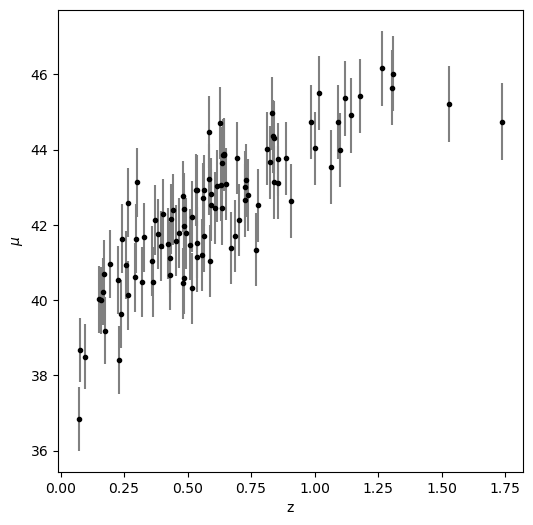

In [4]:
plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor="grey")
plt.xlabel("z")
plt.ylabel("$\\mu$")

## Relevant fitting functions

In [6]:
z_grid = np.linspace(0, 1.2*max(z_sample), 100)

#Linear regression

lr = LinearRegression()
lr.fit(z_ml, mu_sample, dmu)
lr_y = lr.predict(z_grid[:, np.newaxis]).flatten()

#Polinomial regression

def PolReg(X, y, y_err, n_degrees, pred=z_grid):
    pr = PolynomialRegression(degree=n_degrees)
    pr.fit(X, y, y_err)

    return pr.predict(z_grid[:, np.newaxis]).flatten()
    

#Basis function regression

def BasisReg(X, y, y_err, n_bases, grid=z_grid):
    bfr = BasisFunctionRegression(basis_func="gaussian", mu=np.linspace(0, 2, n_bases)[:, np.newaxis], sigma=np.diff(np.linspace(0, 2, n_bases))[0])
    bfr.fit(X, y, y_err)
    
    return bfr.predict(z_grid[:, np.newaxis]).flatten()

#Kernel regression

def KernelReg(X, y, y_err, bw, grid=z_grid):
    nw = NadarayaWatson(kernel="gaussian", h=bw)
    nw.fit(X, y, y_err)
    
    return nw.predict(z_grid[:, np.newaxis]).flatten()

## Linear and polinomial regression

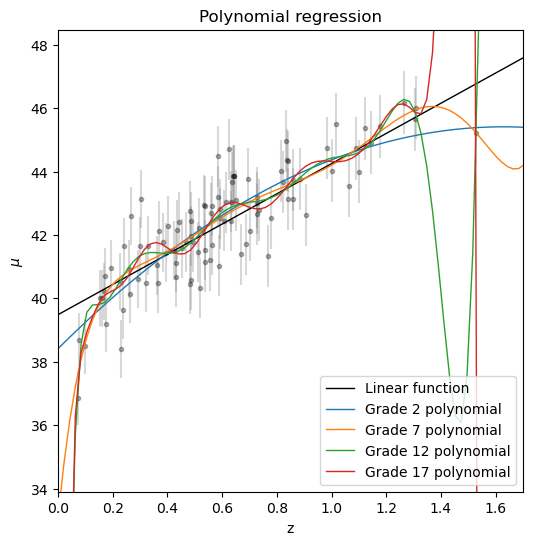

In [8]:
plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor="grey", alpha=0.3, zorder=-1)
plt.plot(z_grid, lr_y, color="black", lw=1, label="Linear function")

for i in range(2, 19, 5):
    plt.plot(z_grid, PolReg(z_ml, mu_sample, dmu, i), lw=1, label="Grade " + str(i) + " polynomial")

plt.title("Polynomial regression")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 1.7)
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

## Basis function regression

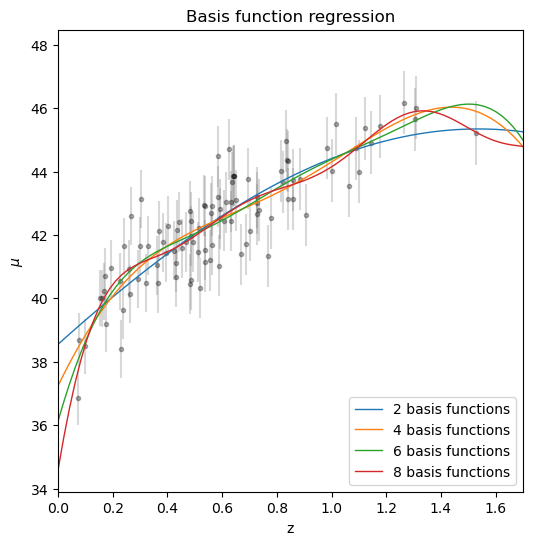

In [10]:
plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor="grey", alpha=0.3, zorder=-1)

for i in range(2, 10, 2):
    plt.plot(z_grid, BasisReg(z_ml, mu_sample, dmu, i), lw=1, label=str(i) + " basis functions")

plt.title("Basis function regression")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 1.7)
plt.ylim(0.92*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

## Kernel regression

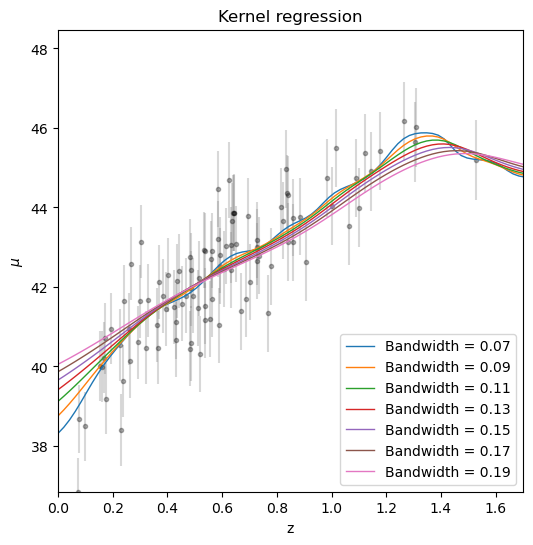

In [12]:
plt.figure()
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor="grey", alpha=0.3, zorder=-1)

for i in np.round(np.arange(0.07, 0.2, 0.02), 2):
    plt.plot(z_grid, KernelReg(z_ml, mu_sample, dmu, i), lw=1, label="Bandwidth = " + str(i))

plt.title("Kernel regression")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 1.7)
plt.ylim(min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")

## Cross validation of the models

In [14]:
#K-fold cross validation

def CrossValidation(X, y, y_err, method, K=10):
    #Train and validation errors
    e_tr = []
    e_val = []

    #Shuffle the data
    X_sh, y_sh, y_err_sh = shuffle(X, y, y_err)

    #Separate data in K sets and train on K - 1 of them

    rkf = KFold(n_splits=K)
    
    for train, test in rkf.split(X_sh, y_sh):
        clf = method
        clf.fit(X_sh[train], y_sh[train], y_err_sh[train])  

        e_tr.append(np.sqrt(np.sum((y_sh[train] - clf.predict(X_sh[train]))**2) / len(X_sh[train])))
        e_val.append(np.sqrt(np.sum((y_sh[test] - clf.predict(X_sh[test]))**2) / len(X_sh[test])))

    return np.mean(e_tr), np.mean(e_val)

In [15]:
degrees = np.arange(0, 20)
n_bases = np.arange(2, 10)
bandwidth = np.arange(0.01, 0.2, 0.02)
K = 20

#Polynomial regression
e_tr_pol, e_val_pol = np.array([CrossValidation(z_ml, mu_sample, dmu, PolynomialRegression(degree=n), K) for n in degrees]).T
best_deg = degrees[np.argsort(e_val_pol)[0]]
print("Best model: n = " + str(best_deg))

#Basis function regression
e_tr_bas, e_val_bas = np.array([CrossValidation(z_ml, mu_sample, dmu, BasisFunctionRegression(basis_func="gaussian", 
                                                                                              mu=np.linspace(0, 2, n)[:, np.newaxis], 
                                                                                              sigma=np.diff(np.linspace(0, 2, n))[0]), K) for n in n_bases]).T
best_basis = n_bases[np.argsort(e_val_bas)[0]]
print("Best model: n_bases = " + str(best_basis))

#Kernel regression
e_tr_k, e_val_k = np.array([CrossValidation(z_ml, mu_sample, dmu, NadarayaWatson(kernel="gaussian", h=n), K) for n in bandwidth]).T
best_bw = bandwidth[np.argsort(e_val_k)[0]]
print("Best model: bandwidth = " + f"{best_bw: .4}")

Best model: n = 5
Best model: n_bases = 5
Best model: bandwidth =  0.03


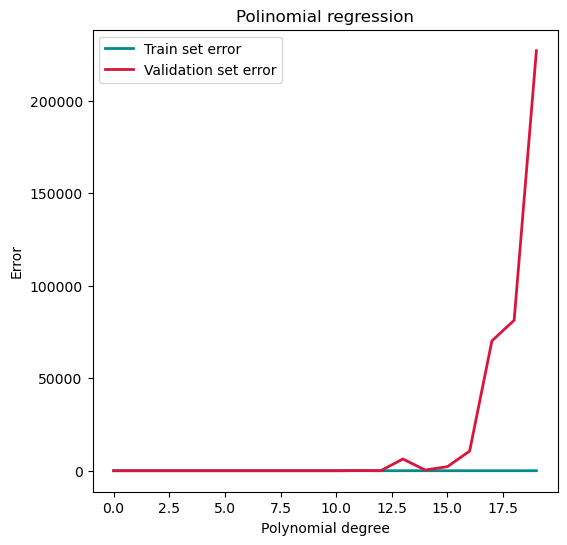

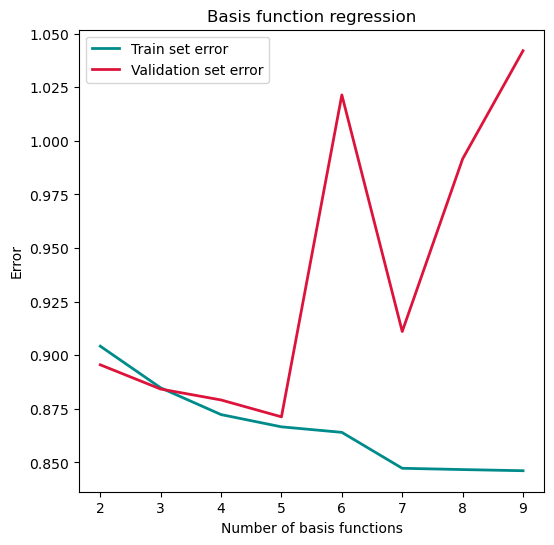

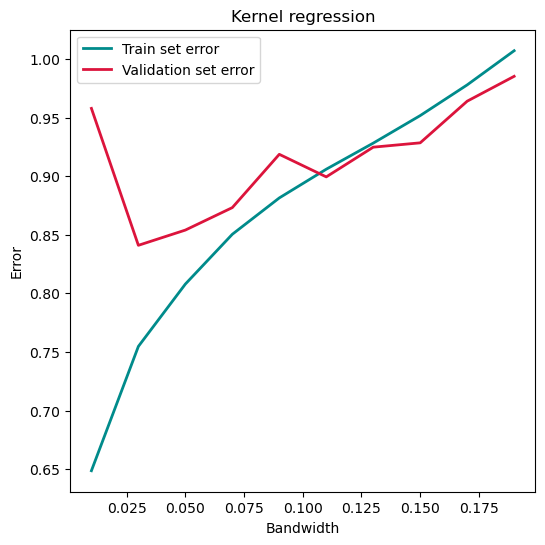

In [16]:
#Plot train and cv rms errors

#Polynomial regression
plt.figure()
plt.plot(degrees, e_tr_pol, color="darkcyan", lw=2, label="Train set error")
plt.plot(degrees, e_val_pol, color="crimson", lw=2, label="Validation set error")
plt.title("Polinomial regression")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.legend()

#Basis function regression
plt.figure()
plt.plot(n_bases, e_tr_bas, color="darkcyan", lw=2, label="Train set error")
plt.plot(n_bases, e_val_bas, color="crimson", lw=2, label="Validation set error")
plt.title("Basis function regression")
plt.xlabel("Number of basis functions")
plt.ylabel("Error")
plt.legend()

#Kernel regression
plt.figure()
plt.plot(bandwidth, e_tr_k, color="darkcyan", lw=2, label="Train set error")
plt.plot(bandwidth, e_val_k, color="crimson", lw=2, label="Validation set error")
plt.title("Kernel regression")
plt.xlabel("Bandwidth")
plt.ylabel("Error")
plt.legend()

## Learning curves

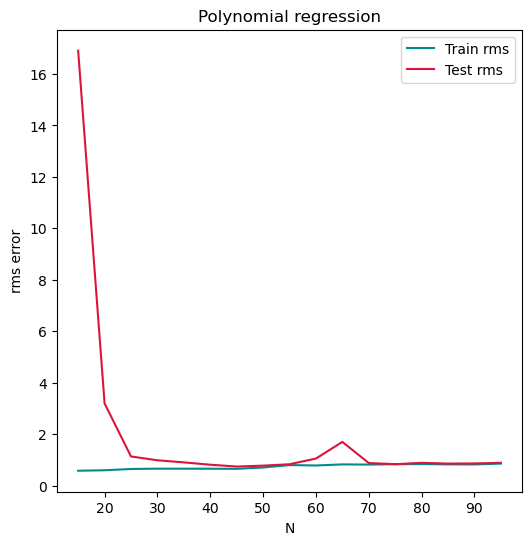

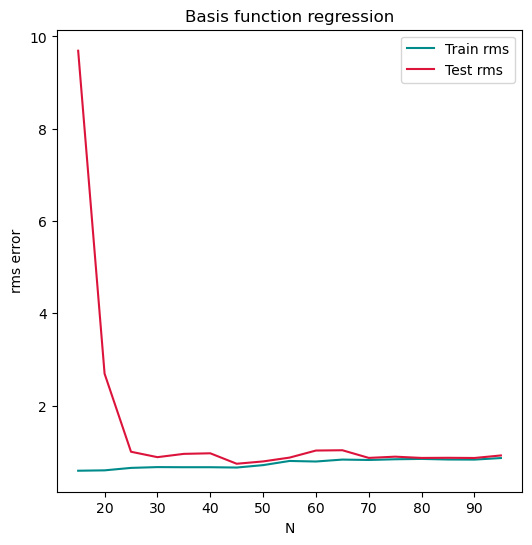

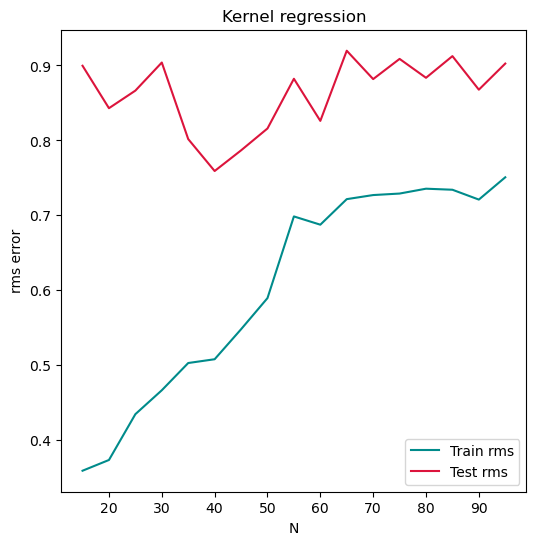

In [18]:
methods = [PolynomialRegression(degree=best_deg), 
           BasisFunctionRegression(basis_func="gaussian", mu=np.linspace(0, 2, best_basis)[:, np.newaxis], sigma=np.diff(np.linspace(0, 2, best_basis))[0]),
           NadarayaWatson(kernel="gaussian", h=best_bw)]

names = ["Polynomial regression", "Basis function regression", "Kernel regression"]

data_size = np.arange(15, len(z_ml), 5)

#Compute the rms errors on train and test sets for various amounts of datapoints

for i, met in enumerate(methods):
    e_tr, e_ts = [], []
    
    for n in data_size:
        tr, ts = CrossValidation(z_ml[:n], mu_sample[:n], dmu[:n], met, 10)
        e_tr.append(tr)
        e_ts.append(ts)
    
    plt.figure()
    plt.plot(data_size, e_tr, color="darkcyan", label="Train rms")
    plt.plot(data_size, e_ts, color="crimson", label="Test rms")
    plt.title(names[i])
    plt.xlabel("N")
    plt.ylabel("rms error")
    plt.legend()

The Kernel regression algorithm seems to require more datapoints, so that the validation and train errors can converge.

## Best fit models

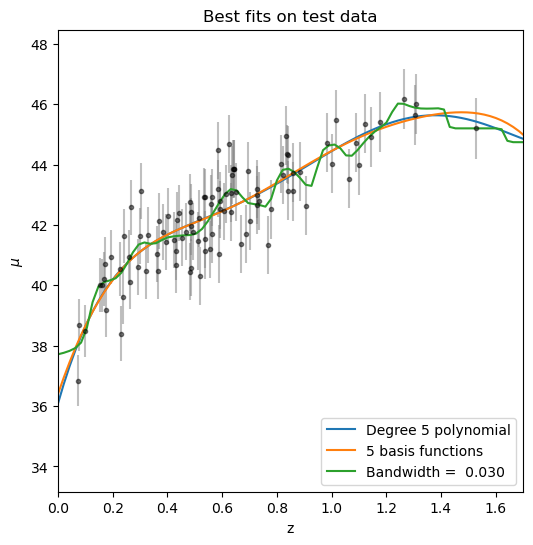

In [21]:
#Plot best fits

plt.figure()
plt.errorbar(z_ml, mu_sample, dmu, color="black", ecolor="grey", linestyle="", marker=".", alpha=0.5)
plt.plot(z_grid, PolReg(z_ml, mu_sample, dmu, best_deg), label="Degree " + str(best_deg) + " polynomial")
plt.plot(z_grid, BasisReg(z_ml, mu_sample, dmu, best_basis), label=str(best_basis) + " basis functions")
plt.plot(z_grid, KernelReg(z_ml, mu_sample, dmu, best_bw), label="Bandwidth = " + f"{best_bw: .3f}")
plt.title("Best fits on test data")
plt.xlabel("z")
plt.ylabel("$\\mu$")
plt.xlim(0, 1.7)
plt.ylim(0.9*min(mu_sample), 1.05*max(mu_sample))
plt.legend(loc="lower right")